### Data Exploration

In [308]:
#Import packages
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
import seaborn as sns

Iport data, convert the fitness to log-fitness so they are additive.  
Then, epistasis is defined as (double mutant fitness - mutant1 fitness - mutant2 fitness).  
Convert amino acids to integers for easier manipulation later.  
Also drop some cloumns that are not used later.

In [309]:
data = pd.read_excel('Data/Olson_Wu_Sun_2014_Epistasis_Dataset.xlsx', 
                     usecols='B:K', header=0, skiprows=2)
data['Mut1 Fitness'] = np.log(data['Mut1 Fitness'])
data['Mut2 Fitness'] = np.log(data['Mut2 Fitness'])

#double mutant fitness is calculated from the experimental data
data.insert(10,  'Double Fitness',
            np.log((data['Selection Count']/data['Input Count'])/(3041819/1759616)))

#calculate epistasis from the data
data.insert(11,  'Epistasis',
            data['Double Fitness']-data['Mut1 Fitness']-data['Mut2 Fitness'])

#clean up data by dropping columns unused hereafter
df = data.drop(['Input Count', 'Selection Count', 'Mut1 WT amino acid', 'Mut2 WT amino acid'], axis=1)
data = df
AA = ['A', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'K', 'L',
       'M', 'N', 'P', 'Q', 'R', 'S', 'T', 'V', 'W', 'Y']
AA_dict = dict((k,v) for v,k in enumerate(AA))

#use integer numbers to represent amino acids
for col in ['Mut1 Mutation', 'Mut2 Mutation']:
    data[col] = list(map(AA_dict.get, data[col]))

c:\Users\leera\anaconda3\lib\site-packages\openpyxl\worksheet\_read_only.py:79: UserWarning: Unknown extension is not supported and will be removed
  for idx, row in parser.parse():
c:\Users\leera\anaconda3\lib\site-packages\pandas\core\arraylike.py:402: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


Import the wildtype sequence. Show some summary of the data.

In [306]:
with open('Data/GB1.txt', 'r', encoding='utf-8') as f:
    seq = f.readlines()[1].strip()
print(f'seq sequence: {seq}')
print(f'seq length: {len(seq)}')
print(f'Number of total double mutants: {data.shape[0]}')
print(f'Theoretical number of double mutants: 55*54/2*(19*19)={int(55*54/2*(19*19))}')
print(f'Number of mutants with zero expression: {int(55*54/2*(19*19))-data.shape[0]}')
data.head()

seq sequence: MQYKLILNGKTLKGETTTEAVDAATAEKVFKQYANDNGVDGEWTYDDATKTFTVTE
seq length: 56
Number of total double mutants: 535917
Theoretical number of double mutants: 55*54/2*(19*19)=536085
Number of mutants with zero expression: 168


,Mut1 Position,Mut1 Mutation,Mut2 Position,Mut2 Mutation,Mut1 Fitness,Mut2 Fitness,Double Fitness,Epistasis
0,2,0,3,0,0.417394,-0.546453,-2.204144,-2.075085
1,2,0,3,1,0.417394,-0.484508,-1.358290,-1.291176
2,2,0,3,2,0.417394,-4.605170,-4.043868,0.143909
3,2,0,3,3,0.417394,-4.710531,-4.824026,-0.530889
4,2,0,3,4,0.417394,0.052592,0.342497,-0.127489


Show histogram for the measured epistasis.  
There are large numbers of both positive and negative epistasis, which is good for testing our hypothesis.  

<Axes: xlabel='Epistasis', ylabel='Count'>

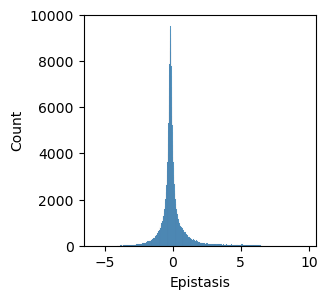

In [226]:
fig, ax = plt.subplots(figsize=(3,3))
sns.histplot(data=data['Epistasis'], ax=ax)
plt.show()

Manipulate the data a bit to extract the single mutant fitnesses.

In [108]:
single_df = data[['Mut1 Position', 'Mut1 Mutation', 'Mut1 Fitness']]
single_df_2 = data[['Mut2 Position', 'Mut2 Mutation', 'Mut2 Fitness']]
single_df = pd.DataFrame(np.vstack((single_df.to_numpy(), single_df_2.to_numpy())), columns=single_df.columns)
single_df = single_df.drop_duplicates()
single_df = single_df.sort_values(by=['Mut1 Position', 'Mut1 Mutation'])

### Training Lasso regression model using only the single mutants, on UniRep embedding.

Load the single mutant embeddings. Using that and the measurement data, define training and testing sets.  
UniRep provides different dimension options for embeddings - 64, 256, and 1900.  
Because we are going to train on small number of data (1,045 single mutants), and due to time constraints I chose the 64-dim embedding.

In [112]:
embedding_single_mutations = pd.read_csv('Data/mutation_input/single_mutations.csv', 
                                         usecols=[0,1], dtype='int', names=['Mut1 Position', 'Mut1 Mutation'])
embedding_single_data = pd.read_csv('Data/embedding_output/final_cell_single_mutations.csv', names=[str(x) for x in range(64)])
embedding_concat = pd.concat([embedding_single_mutations, embedding_single_data], axis=1)
embedding_concat = embedding_concat.sort_values(by=['Mut1 Position', 'Mut1 Mutation'])
X = embedding_concat.iloc[:,2:].to_numpy()
y = single_df['Mut1 Fitness'].to_numpy().reshape(-1,1)

In [192]:
from sklearn.linear_model import Lasso
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error as MSE

scaler = StandardScaler()

X_train, X_test, y_train, y_test = train_test_split(X, y,
                                        random_state = 42)
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

Train Lasso regression model with different alpha values.  
I chose Lasso because the feature dimension (64) is relatively large for the number of training data (1,045).  
The model performs poorly. In Alley et al., sparse linear model built on an expanded 5700-dim embedding performed much better for protein stability prediction on a different dataset. It would take more time to do proper exploration of the reason behind the poor performance here.

In [187]:
# This code was adapted from Coursera|University of Michigan|Applied Machine Learning in Python 
for alpha in [0.0001, 0.001, 0.01]:
    linlasso = Lasso(alpha, max_iter = 100000).fit(X_train_scaled, y_train)
    r2_train = linlasso.score(X_train_scaled, y_train)
    r2_test = linlasso.score(X_test_scaled, y_test)
    MSE_train = MSE(y_train, linlasso.predict(X_train_scaled))
    MSE_test = MSE(y_test, linlasso.predict(X_test_scaled))
    
    print('Alpha = {:.5f}\nFeatures kept: {}, r-squared training: {:.5f}, \
r-squared test: {:.5f}, MSE training: {:.5f}, MSE test: {:.5f}\n'
         .format(alpha, np.sum(linlasso.coef_ != 0), r2_train, r2_test, MSE_train, MSE_test))

Alpha = 0.00010
Features kept: 64, r-squared training: 0.36113, r-squared test: 0.33864, MSE training: 2.36297, MSE test: 2.66651

Alpha = 0.00100
Features kept: 61, r-squared training: 0.36027, r-squared test: 0.34187, MSE training: 2.36618, MSE test: 2.65350

Alpha = 0.01000
Features kept: 46, r-squared training: 0.33386, r-squared test: 0.33179, MSE training: 2.46385, MSE test: 2.69413



Some visual comparison of the model-predicted and measured single mutant fitness

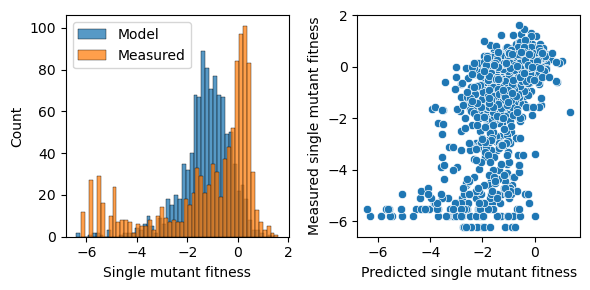

In [299]:
single_mutation_identity = embedding_concat.iloc[:,[0,1]].to_numpy()
X_scaled = scaler.transform(X)
y_single_pred = linlasso.predict(X_scaled)
fig, ax = plt.subplots(1,2, figsize=(6,3))

sns.histplot(data=y_single_pred, bins=50, ax=ax[0], label='Model')
sns.histplot(data=single_df['Mut1 Fitness'], bins=50, ax=ax[0], label='Measured')
ax[0].set_xlabel('Single mutant fitness')
ax[0].legend()

sns.scatterplot(x=y_single_pred, y=single_df['Mut1 Fitness'], ax=ax[1])
ax[1].set_xlabel('Predicted single mutant fitness')
ax[1].set_ylabel('Measured single mutant fitness')
fig.tight_layout()
plt.show()

Because the model fit is so poor, we are probably unlikely to get a meaningful result for our original goal of predicting epistasis.  
But we still proceed with this model to show the workflow.

### Prediction of double mutant fitness and epistasis

We import the double mutant embeddings and make predictions for the mutant fitness.  
Then subtract from it the "no epistasis" prediction which is just the sum of two corresponding single mutant fitness predictions.

In [273]:
y_single_pred = y_single_pred.reshape(55,19)
y_double_pred = np.zeros((1485, 19, 19))
y_double_pred_lin = np.zeros((1485, 19, 19))

for i in range(0,54):
    for j in range(i+1,55):
        embedding_double_data = \
            np.genfromtxt('Data/embedding_output/final_cell_double_mutations_{0:d}_{1:d}.csv'.format(i+1,j+1), delimiter=',')
        X_scaled = scaler.transform(embedding_double_data)
        y_double_pred[sum(range(55-i,55))+j-i-1, :, :] = linlasso.predict(X_scaled).reshape((19,19))
        y_double_pred_lin[sum(range(55-i,55))+j-i-1, :, :] = y_single_pred[[i],:] + y_single_pred[[j],:].T

Some visual comparison of  
(1) model-predicted and measured double mutant fitness,
(2) model-predicted and "no epistasis" model double mutant fitness

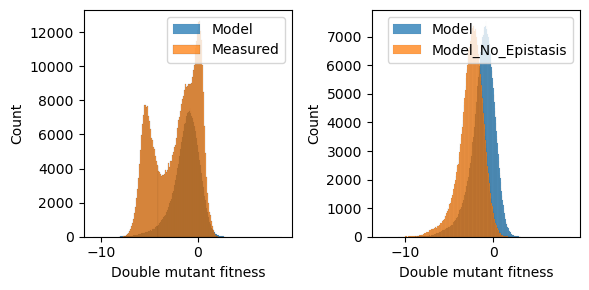

In [311]:
fig, ax = plt.subplots(1,2,figsize=(6,3))
sns.histplot(data=y_double_pred.ravel(), ax=ax[0], label='Model')
sns.histplot(data=data['Double Fitness'], ax=ax[0], label='Measured')
ax[0].set_xlabel('Double mutant fitness')
ax[0].legend()

sns.histplot(data=y_double_pred.ravel(), ax=ax[1], label='Model')
sns.histplot(data=y_double_pred_lin.ravel(), ax=ax[1], label='Model_No_Epistasis')
ax[1].set_xlabel('Double mutant fitness')
ax[1].legend()

fig.tight_layout()
plt.show()


Now compare the model-predicted epistasis and the measured epistasis.
First we manipulate the arrays so we can compare them.

In [291]:
y_epistasis_pred = y_double_pred - y_double_pred_lin
epistasis_measured_arr = np.zeros((1485, 19, 19))
variable_seq_int = list(map(AA_dict.get, seq[1:]))
for k in range(data.shape[0]):
    i, muti, j, mutj = tuple(data.iloc[k,0:4].astype(int))
    i -= 2; j -= 2
    if muti > variable_seq_int[i]:
        muti -= 1
    if mutj > variable_seq_int[j]:
        mutj -= 1
    if i > j:
        i,j = j,i
        muti, mutj = mutj, muti
    epistasis_measured_arr[sum(range(55-i,55))+j-i-1, muti, mutj] = data.iloc[k,-1]

As already expected, the model does a very bad job of predicting epistasis.  
At this point, this is likely a direct consequence of the fact that the model has low accuracy even for the training set.  
We would need to address that before we can get to our original goal of asking whether learned embeddings help predict epistasis.  
For example, it may be that training on only single mutants is not a good choice because the number of data points is so small. Instead, we could perhaps divide up the double mutants into training and test groups, so that some residue pairs only appear in the training set and others only appear in the test set.

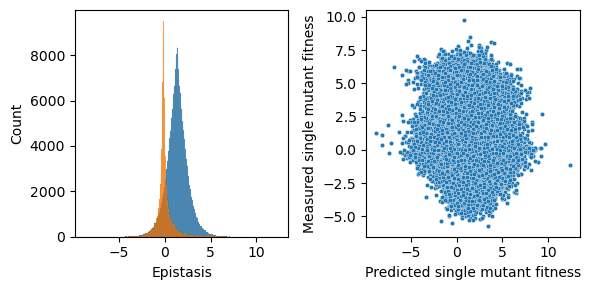

In [305]:
fig, ax = plt.subplots(1,2,figsize=(6,3))
sns.histplot(data=y_epistasis_pred.ravel(), ax=ax[0], label='Predicted')
sns.histplot(data=epistasis_measured_arr.ravel(), ax=ax[0], label='Measured')
ax[0].set_xlabel('Epistasis')

sns.scatterplot(x=y_epistasis_pred.ravel(), y=epistasis_measured_arr.ravel(), ax=ax[1], s=10)
ax[1].set_xlabel('Predicted single mutant fitness')
ax[1].set_ylabel('Measured single mutant fitness')

fig.tight_layout()